In [1]:
# GET the data
## Memuat Data
import pandas as pd

dataset = pd.read_csv("Capres2014-1.1.csv", usecols=["Isi_Tweet", "Sentimen"])

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# EXPLORE the data
## Menampilkan lima data terakhir
dataset.head()

,Isi_Tweet,Sentimen
0,"Biusnya habis ! RT""@eddies_song: Dahlan Iskan ...",-1
1,"Presiden Prabowo ,Presiden Terakhir Indonesia",1
2,@republikaonline masa capres prabowo bergitu b...,-1
3,"Kalo kata bapak capres ARB, kita harus ""berani...",1
4,"RT @DhafaRizky_: Najis,org gila doang yg dukun...",-1


In [4]:
## Mengecek Imbalanced Data
dataset['Sentimen'].value_counts()

 1    1117
-1     768
Name: Sentimen, dtype: int64

In [5]:
bool_series = dataset.duplicated(subset='Isi_Tweet')

print('Boolean series:')
print(bool_series)
print('\n')
print('DataFrame after removing duplicates found in the Name column:')
dataset = dataset[~bool_series]
dataset

Boolean series:
0       False
1       False
2       False
3       False
4       False
        ...  
1880    False
1881    False
1882    False
1883    False
1884    False
Length: 1885, dtype: bool


DataFrame after removing duplicates found in the Name column:


,Isi_Tweet,Sentimen
0,"Biusnya habis ! RT""@eddies_song: Dahlan Iskan ...",-1
1,"Presiden Prabowo ,Presiden Terakhir Indonesia",1
2,@republikaonline masa capres prabowo bergitu b...,-1
3,"Kalo kata bapak capres ARB, kita harus ""berani...",1
4,"RT @DhafaRizky_: Najis,org gila doang yg dukun...",-1
...,...,...
1880,Jangan kabur dari tanggung jawab dengan kemasa...,1
1881,@echo_hadiwibowo mana berani pmrntah..m G da y...,1
1882,@IndonesiaCapres ANAK MEDAN DUKUNG CAPRES JK D...,1
1883,"RT @idoidonajib: Jelek! ""@fallenokta: Apa komp...",1


In [6]:
data1 = dataset[dataset['Sentimen']==1]
data2 = dataset[dataset['Sentimen']==-1]
data2_ = pd.concat([data2.iloc[0:318], data2])
dataset = pd.concat([data1, data2_])
dataset = dataset.sample(frac = 1)
dataset.reset_index(inplace = True)
dataset.drop(["index"], axis = 1, inplace = True)

dataset

,Isi_Tweet,Sentimen
0,Karena mereka akan menjadi presiden hanya di s...,-1
1,"Mubes Kosgoro 1957 telah selesai d laksanakan,...",1
2,"Haha...jancuk tenan""@fadjroeL: Hehehe keren RT...",1
3,@TheComment_NET Hi #mynameis Bakrie / Capres? ...,-1
4,@aburizalbakrie subhanalloh...sukses terus cap...,1
...,...,...
1909,Iklan/Kampanye Capres ARB pun menyinggung masa...,1
1910,RT @betynurbaety: Padahal belum tentu pada jad...,-1
1911,Hidup titisan suharto... Capres Prabowo!! Naik...,1
1912,"@ulinyusron @sociotalker ahok capres, jokowi t...",-1


In [7]:
## Mengganti {-1,1} menjadi {0,1}
dataset['Sentimen'] = dataset['Sentimen'].replace(-1,0)
dataset.head()

,Isi_Tweet,Sentimen
0,Karena mereka akan menjadi presiden hanya di s...,0
1,"Mubes Kosgoro 1957 telah selesai d laksanakan,...",1
2,"Haha...jancuk tenan""@fadjroeL: Hehehe keren RT...",1
3,@TheComment_NET Hi #mynameis Bakrie / Capres? ...,0
4,@aburizalbakrie subhanalloh...sukses terus cap...,1


In [8]:
dataset['Sentimen'].value_counts()

0    957
1    957
Name: Sentimen, dtype: int64

In [9]:
# MODEL the data
## Pra Pengolahan - Cleaning
import numpy as np
import re
import string

def clean_text(tweet):
    
    # Convert to lower case
    tweet = tweet.lower()
    # remove unicode characters
    tweet = tweet.encode('ascii', 'ignore').decode()
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub('\[.*?\]', '', tweet)
    tweet = re.sub(r"\d+", "", tweet)
    tweet = re.sub("\\W"," ",tweet) 
    tweet = re.sub('https?://\S+|www\.\S+', '', tweet)
    tweet = re.sub('<.*?>+', '', tweet)
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)
    tweet = re.sub('\n', '', tweet)
    tweet = re.sub('\w*\d\w*', '', tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('\,', ' ', tweet)
    tweet = re.sub('\)', ' ', tweet)
    tweet = re.sub('\:', ' ', tweet)
    tweet = re.sub('\-', ' ', tweet)
    tweet = re.sub('\!', ' ', tweet)
    tweet = re.sub('\"', ' ', tweet)
    tweet = re.sub('\.', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    
    return tweet

dataset["Isi_Tweet"] = dataset['Isi_Tweet'].map(lambda x: clean_text(x))
# Convert the titles to lowercase
dataset["Isi_Tweet"] = dataset["Isi_Tweet"].map(lambda x: x.lower())
dataset = dataset[dataset['Isi_Tweet'].apply(lambda x: len(x.split()) >=1)]
dataset.shape

(1914, 2)

In [10]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

In [11]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

def wordopt(text):
    text = re.sub(' tersebut ', '', text)
    text = re.sub(' gak ', ' tidak ', text)
    text = re.sub(' tdk ', ' tidak ', text)
    text = re.sub(' tak ', ' tidak ', text)
    text = re.sub(' ga ', ' tidak ', text)
    text = re.sub(' gk ', ' tidak ', text)
    text = re.sub(' tidak ', ' ', text)
    text = re.sub('yg ', 'yang ', text)
    text = re.sub(' yang ', ' ', text)
    text = re.sub(' tp ', ' tapi ', text)
    text = re.sub(' jdi ', ' jadi ', text)
    text = re.sub(' jd ', ' jadi ', text)
    text = re.sub(' jadi ', ' ', text)
    text = re.sub(' org ', ' orang ', text)
    text = re.sub(' hehe ', ' ', text)
    text = re.sub(' hehehe ', ' ', text)
    text = re.sub(' wakakak ', ' ', text)
    text = re.sub(' jls ', ' jelas ', text)
    text = re.sub(' sdh ', ' sudah ', text)
    text = re.sub(' trus ', ' terus ', text)
    text = re.sub(' utk ', ' untuk ', text)
    text = re.sub(' wapres ', ' cawapres ', text)
    text = re.sub(' utk ', ' untuk ', text)
    text = re.sub(' sy ', ' saya ', text)
    text = re.sub(' aku ', ' saya ', text)
    text = re.sub(' gue ', ' saya ', text)
    text = re.sub(' blm ', ' belum ', text)
    text = re.sub('klo ', ' kalau ', text)
    text = re.sub('kalo ', ' kalau ', text)
    text = re.sub(' kalau ', ' ', text)
    text = re.sub(' calon presiden ', ' capres ', text)
    text = re.sub(' mega ', ' megawati ', text)
    text = re.sub(' jkt ', ' jakarta ', text)
    text = re.sub(' deh ', ' ', text)
    text = re.sub('2013', '', text)
    text = re.sub(' rt ', ' ', text)
    text = re.sub(' wakilnya ', ' wakil ', text)
    text = re.sub(' lg ', ' ', text)
    text = re.sub(' gt ', ' ', text)
    text = re.sub(' ahhh ', ' ', text)
    text = re.sub(' cm ', ' ', text)
    text = re.sub(' dr ', ' ', text)
    text = re.sub(' kan ', ' ', text)
    text = re.sub(' ibu ', ' ', text)
    text = re.sub(' akn ', ' akan ', text)
    text = re.sub(' nih ', ' ', text)
    text = re.sub(' jg ', ' ', text)
    text = re.sub(' cawapresnya ', ' cawapres ', text)
    text = re.sub(' pak ', ' ', text)
    text = re.sub(' followradiopepatah ',' ',text)
    text = re.sub(' d ', ' ', text)
    text = re.sub(' p ', ' ', text)
    text = re.sub('rt ', ' ', text)
    text = re.sub(' bu ', ' ', text)
    text = re.sub(' b ', ' ', text)
    text = re.sub(' jgn ', ' ', text)
    text = re.sub(' sbg ', ' ', text)
    text = re.sub(' pd ', ' ', text)
    text = re.sub(' pa ', ' ', text)
    text = re.sub(' pas ', ' ', text)
    text = re.sub(' b ', ' ', text)
    text = re.sub(' kok ', ' ', text)
    text = re.sub(' masa ', ' ', text)
    text = re.sub(' om ', ' ', text)
    text = re.sub(' siapa ', ' ', text)
    text = re.sub(' ada ', ' ', text)
    text = re.sub(' gub ', ' gubernur ', text)
    text = re.sub(' apa ', ' ', text)
    text = re.sub(' aja ', ' ', text)
    text = re.sub(' joko widodo ', ' jokowi ', text)
    text = re.sub('tuit', ' ', text)
    text = re.sub(' nya ', ' ', text)
    text = re.sub(' jusuf kalla ', ' jk ', text)
    text = re.sub(' dong ', ' ', text)
    text = re.sub(' cuma ', ' ', text)
    text = re.sub(' dgn ', ' ', text)
    text = re.sub(' dg ', ' ', text)
    text = re.sub(' dong ', ' ', text)
    text = re.sub(' hayoo ', ' ', text)
    text = re.sub(' mau ', ' ingin ', text)
    text = re.sub(' ndak ', ' tidak ', text)
    text = re.sub(' pikir ', ' berpikir ', text)

    return text

dataset["Isi_Tweet"] = dataset["Isi_Tweet"].apply(wordopt)
dataset["Isi_Tweet"] = dataset["Isi_Tweet"].apply(stopword.remove)
dataset.shape

(1914, 2)

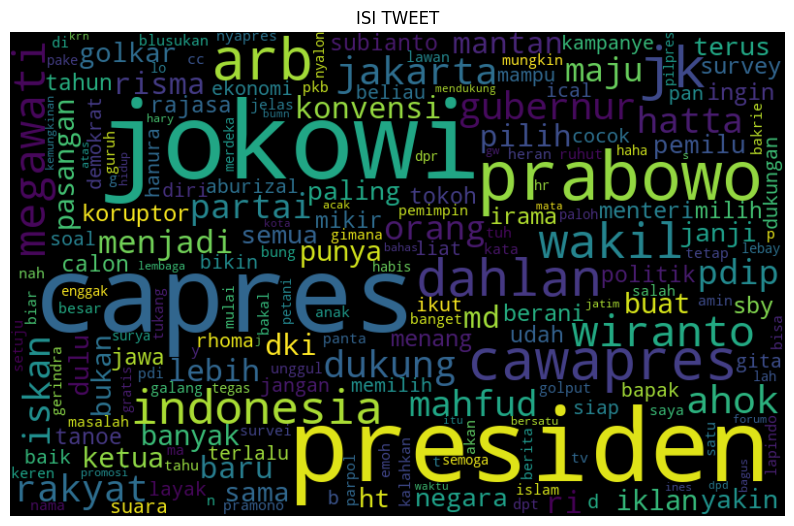

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_word = ' '.join(dataset["Isi_Tweet"])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False).generate(all_word)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("ISI TWEET")
plt.show()

In [13]:
## Pra Pengolahan - Splitting
from sklearn.model_selection import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(xt, y, test_size=0.2)
train_data, test_data, train_labels, test_labels = train_test_split(dataset['Isi_Tweet'], dataset['Sentimen'], test_size=0.1,random_state=42)

In [14]:
from tensorflow import keras
from transformers import AutoTokenizer, TFAutoModel
import IPython

bert_tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
def tokenisasi(teks):
    encode_dict = bert_tokenizer(teks,
                                   add_special_tokens = True,
                                   max_length = 128, 
                                   padding = 'max_length',
                                   truncation = True,
                                   return_attention_mask = True,
                                   return_tensors = 'tf',)

    tokenID = encode_dict['input_ids']
    attention_mask = encode_dict['attention_mask']

    return tokenID, attention_mask

def create_input(data):
    tokenID, input_mask = [], []
    for teks in data:
        token, mask = tokenisasi(teks)
        tokenID.append(token)
        input_mask.append(mask)
    
    return [np.asarray(tokenID, dtype=np.int32).reshape(-1, 128), 
            np.asarray(input_mask, dtype=np.int32).reshape(-1,128)]

bert_model = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2", trainable=False)
def bert(hp):
    
    #Input layer
    input_token = keras.layers.Input(shape=(128,), dtype=np.int32,
                                    name="input_token")
    input_mask = keras.layers.Input(shape=(128,), dtype=np.int32,
                                   name="input_mask")

    #Embedding
    bert_embedding = bert_model([input_token, input_mask])[0]

    #Output layer
    activation_function=hp.Choice('activation function', values=['sigmoid','tanh','relu'])
    output = keras.layers.Dense(1, activation=activation_function,
                                kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.01, 0.001])))(bert_embedding)
    
    model = keras.models.Model(inputs=[input_token, input_mask], outputs=output)
    opt=keras.optimizers.Adam(
        learning_rate=hp.Float('lr',1e-6,1e-3,sampling='log'),
        decay=hp.Float('weight decay',1e-5,1e-2,sampling='log')
    )
    model.compile(optimizer = opt,
                  loss ='binary_crossentropy',
                  metrics=['accuracy'])
   
    return model

class ClearTrainingOutput(keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:
from keras_tuner.tuners import BayesianOptimization

bert_train_data = create_input(train_data)
bert_test_data = create_input(test_data)


tuner = BayesianOptimization(bert,
                             objective = 'val_accuracy', 
                             max_trials = 10,
                             directory = '/content/Hasil',
                             project_name = 'Sentiment-BERT',
                             overwrite = True)
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation function (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'tanh', 'relu'], 'ordered': False}
kernel_dense (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.001, 'step': None, 'sampling': 'log'}
weight decay (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [16]:
tuner.search(bert_train_data, train_labels,
             batch_size=32, epochs=100,
             validation_data=(bert_test_data, test_labels),
             callbacks=[early_stop, ClearTrainingOutput()])

#best_hps = tuner.get_best_hyperparameters()[0]
#model = tuner.hypermodel.build(best_hps)
# Mendapatkan model terbaik
model = tuner.get_best_models()[0]


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
tanh              |?                 |activation function
0.01              |?                 |kernel_dense
0.00080814        |?                 |lr
2.3475e-05        |?                 |weight decay

Epoch 1/100
54/54 [==============================] - 44s 635ms/step - loss: 1.9396 - accuracy: 0.5192 - val_loss: 1.5886 - val_accuracy: 0.5902
Epoch 2/100
54/54 [==============================] - 33s 610ms/step - loss: 1.6567 - accuracy: 0.5231 - val_loss: 1.5742 - val_accuracy: 0.6045
Epoch 3/100
54/54 [==============================] - 34s 623ms/step - loss: 1.6127 - accuracy: 0.5347 - val_loss: 1.5378 - val_accuracy: 0.6066
Epoch 4/100
54/54 [==============================] - 35s 641ms/step - loss: 1.5070 - accuracy: 0.5484 - val_loss: 1.4067 - val_accuracy: 0.6090
Epoch 5/100
54/54 [==============================] - 35s 647ms/step - loss: 1.7415 - accuracy: 0.5237 - val_loss: 1.4179 - val_accuracy: 0.615

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(bert_test_data, test_labels)
print('Test accuracy:', test_acc)

In [ ]:
model.save('Data/model_mlp_sentiment.h5')

#model = keras.models.load_model('Data/model_mlp_sentiment.h5')